# Mini Project: Modeling & Simulation
## Optimization: Comparison between batch, stochastic and mini-batch techniques
---
**Created by:** Harold H. Rodriguez R.\
**Contact:** rodriguezhh03@gmail.com

### Import Libraries

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

### Load data from Google Drive

In [22]:
# Ruta al archivo .dat en tu Google Drive
file_path = 'output.dat'

# Lee el archivo .dat como una matriz NumPy
data = np.loadtxt(file_path)

### Global Functions

In [23]:
# Definimos la función de costo llamada "mean_square_error"
def mean_square_error_batch(data, y_pred):
    # Extraemos la segunda columna de 'data' que contiene los valores reales 'y'
    y = data[:, 1]

    # Calculamos el error restando las predicciones 'y_pred' de los valores reales 'y' a partir del tercer elemento
    error = y[2:] - y_pred

    # Calculamos la suma de los cuadrados de los errores
    error_sum = np.sum(error ** 2)

    # Calculamos el costo dividiendo la suma de los cuadrados de los errores por el número de elementos - 2
    cost = error_sum / (len(y) - 2)

    # Retornamos el valor del costo
    return cost

In [24]:
def predict_batch(data, weights):
    # Extract the first column of 'data' which contains the values of 'u'
    u = data[:, 0]
    # Extract the second column of 'data' which contains the actual values 'y'
    y = data[:, 1]

    # Unpack the weights into four variables: a1, a2, b1, and b2
    a1, a2, b1, b2 = weights

    # Calculate the predictions 'y_pred' using the provided formula
    # Utilize the shifted values of 'y' and 'u' to create the predictions
    y_pred = -a1 * y[1:-1] - a2 * y[:-2] + b1 * u[1:-1] + b2 * u[:-2]

    # Return the array of predictions 'y_pred'
    return y_pred

In [25]:
def gradient_batch(cost_function, weights, data):
    """
    Calcula el gradiente de una función f con respecto a un vector x.

    Args:
        f (función): La función para la cual se calculará el gradiente.
        x (numpy.ndarray): El punto en el que se calculará el gradiente.

    Returns:
        numpy.ndarray: El vector gradiente.
    """
    epsilon = 1e-6  # Valor pequeño para la diferenciación numérica
    n = len(weights)  # Número de variables
    grad = np.zeros(n)  # Inicializa el vector gradiente

    for i in range(n):
        # Perturba la i-ésima componente de x
        x_perturbado = weights.copy()
        x_perturbado[i] += epsilon

        # Calcula la derivada parcial utilizando la diferencia central
        grad[i] = (cost_function(data, predict_batch(data,x_perturbado)) - cost_function(data, predict_batch(data,weights))) / epsilon

    return grad

In [26]:
def batch_train(data, cost_function, epochs, learning_rate=0.01):
    """
    Trains the model using batch gradient descent.

    Parameters:
    data (array): The dataset, where columns correspond to features and target values.
    cost_function (function): The function used to compute the cost (e.g., mean squared error).
    epochs (int): The number of iterations for training.
    learning_rate (float, optional): The step size for updating the weights. Default is 0.01.

    Returns:
    tuple: The final weights and the cost history over epochs.
    """
    # Initialize weights to zero (for a model with four parameters)
    weights = np.array([0.0, 0.0, 0.0, 0.0])
    # Initialize an array to store the cost at each epoch
    cost = np.zeros(epochs)

    # Loop over the number of epochs
    for epoch in range(epochs):
        # Predict the output using the current weights
        y_pred = predict_batch(data, weights)
        # Calculate the mean squared error using the cost function
        mse = cost_function(data, y_pred)
        # Store the cost for the current epoch
        cost[epoch] = mse
        # Compute the gradient of the cost function with respect to the weights
        grad = gradient_batch(cost_function, weights, data)
        # Update the weights by moving in the direction of the negative gradient
        weights = weights - learning_rate * grad

        # Print the current epoch, cost, and weights
        print(str(epoch + 1) + '/' + str(epochs) + '--------------------------------------------------------------------------')
        print('MSE = ', mse, 'Weights = ', weights)

    # Return the final weights and the cost history
    return weights, cost


In [27]:
def plot_cost(cost_values):
    """
    Plots the cost values over epochs.

    Parameters:
    cost_values (list or array): A list or array of cost values for each epoch.

    """
    # Generate an array of epoch numbers
    epochs = range(1, len(cost_values) + 1)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, cost_values, linestyle='-', color='b', label='Cost')
    
    # Add titles and labels
    plt.title('Cost per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    
    # Add a grid
    plt.grid(True)
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()

In [53]:
weights_batch, cost_batch = batch_train(data, mean_square_error_batch, 100, learning_rate=0.001)

1/100--------------------------------------------------------------------------
MSE =  27.52275730205167 Weights =  [-0.04901698 -0.0346945   0.00190773  0.003907  ]
2/100--------------------------------------------------------------------------
MSE =  24.080457969342504 Weights =  [-0.0936279  -0.06507717  0.00381762  0.00771523]
3/100--------------------------------------------------------------------------
MSE =  21.296006533978943 Weights =  [-0.13428684 -0.0916013   0.00572906  0.01143297]
4/100--------------------------------------------------------------------------
MSE =  19.039865332971747 Weights =  [-0.17140064 -0.11467297  0.00764149  0.01506767]
5/100--------------------------------------------------------------------------
MSE =  17.208053643559676 Weights =  [-0.20533383 -0.13465596  0.00955442  0.01862599]
6/100--------------------------------------------------------------------------
MSE =  15.717104831998519 Weights =  [-0.23641302 -0.15187619  0.01146739  0.02211393]

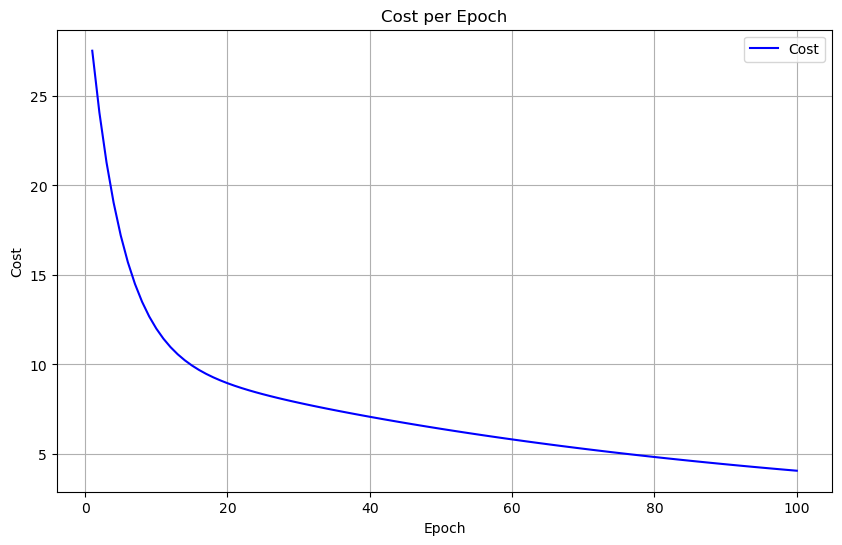

In [54]:
plot_cost(cost_batch)

### Stochastic tecnique

In [30]:
# Definimos la función de costo llamada "mean_square_error"
def mean_square_error_stochastic(data, y_pred, index):
    # Extraemos la segunda columna de 'data' que contiene los valores reales 'y'
    y = data[:, 1]

    # Calculamos el error restando las predicciones 'y_pred' de los valores reales 'y' a partir del tercer elemento
    error = y[index] - y_pred

    # Calculamos la suma de los cuadrados de los errores
    error_sum = np.sum(error ** 2)

    # Calculamos el costo dividiendo la suma de los cuadrados de los errores por el número de elementos - 2
    cost = error_sum / 1

    # Retornamos el valor del costo
    return cost

In [31]:
def predict_stochastic(data, weights, index):
    # Extract the first column of 'data' which contains the values of 'u'
    u = data[:, 0]
    # Extract the second column of 'data' which contains the actual values 'y'
    y = data[:, 1]

    # Unpack the weights into four variables: a1, a2, b1, and b2
    a1, a2, b1, b2 = weights

    # Calculate the predictions 'y_pred' using the provided formula
    # Utilize the shifted values of 'y' and 'u' to create the predictions
    y_pred = -a1 * y[index-1] - a2 * y[index-2] + b1 * u[index-1] + b2 * u[index-2]

    # Return the array of predictions 'y_pred'
    return y_pred

In [32]:
def gradient_stochastic(cost_function, weights, data, index):
    """
    Calcula el gradiente de una función f con respecto a un vector x.

    Args:
        f (función): La función para la cual se calculará el gradiente.
        x (numpy.ndarray): El punto en el que se calculará el gradiente.

    Returns:
        numpy.ndarray: El vector gradiente.
    """
    epsilon = 1e-6  # Valor pequeño para la diferenciación numérica
    n = len(weights)  # Número de variables
    grad = np.zeros(n)  # Inicializa el vector gradiente

    for i in range(n):
        # Perturba la i-ésima componente de x
        x_perturbado = weights.copy()
        x_perturbado[i] += epsilon

        # Calcula la derivada parcial utilizando la diferencia central
        grad[i] = (cost_function(data, predict_stochastic(data,x_perturbado, index),index) - cost_function(data, predict_stochastic(data,weights, index),index)) / epsilon

    return grad

In [37]:
def stochastic_train(data, cost_function, epochs, learning_rate=0.01):
    """
    Trains the model using stochastic gradient descent.

    Parameters:
    data (array): The dataset, where columns correspond to features and target values.
    cost_function (function): The function used to compute the cost (e.g., mean squared error).
    epochs (int): The number of iterations for training.
    learning_rate (float, optional): The step size for updating the weights. Default is 0.01.

    Returns:
    tuple: The final weights and the cost history over epochs.
    """
    # Initialize weights to zero (for a model with four parameters)
    weights = np.array([0.0, 0.0, 0.0, 0.0])
    # Initialize an array to store the cost at each epoch
    cost = np.zeros(epochs)

    # Loop over the number of epochs
    for epoch in range(epochs):
        # Create a list of available indices (excluding the first two)
        available_indices = list(range(2, len(data)))
        # Loop over the dataset, starting from index 2 to the end
        for sample in range(2, len(data)):
            # Select a random index from the available indices
            selected_index = random.choice(available_indices)
            # Predict the output for the selected sample using the current weights
            y_pred = predict_stochastic(data, weights, selected_index)
            # Compute the gradient of the cost function for the selected sample
            grad = gradient_stochastic(cost_function, weights, data, selected_index)
            # Update the weights using the computed gradient
            weights = weights - learning_rate * grad
            # Remove the selected index from the list of available indices
            available_indices.remove(selected_index)
        
        # Compute the mean squared error for the entire batch
        mse = cost_function(data, predict_batch(data, weights))
        # Store the cost for the current epoch
        cost[epoch] = mse

        # Print the current epoch, cost, and weights
        print(str(epoch + 1) + '/' + str(epochs) + '--------------------------------------------------------------------------')
        print('MSE = ', mse, 'Weights = ', weights)

    # Return the final weights and the cost history
    return weights, cost

In [35]:
weights_stochastic, cost_stochastic = stochastic_train(data, mean_square_error_stochastic, 100, learning_rate=0.002)

1/100--------------------------------------------------------------------------
MSE =  1.186329547969607 Weights =  [-1.50972127  0.79289479  0.97463542  0.50183908]
2/100--------------------------------------------------------------------------
MSE =  1.0862268553733228 Weights =  [-1.56858103  0.71849198  1.02376731  0.46067545]
3/100--------------------------------------------------------------------------
MSE =  1.015807374853204 Weights =  [-1.53772608  0.72925845  1.0232899   0.49424508]
4/100--------------------------------------------------------------------------
MSE =  1.5163736455595285 Weights =  [-1.58225892  0.64867191  1.07030213  0.57332407]
5/100--------------------------------------------------------------------------
MSE =  1.025364900104991 Weights =  [-1.49665675  0.72287481  1.05013833  0.48721739]
6/100--------------------------------------------------------------------------
MSE =  1.408008631949146 Weights =  [-1.44568082  0.77249556  0.91548568  0.53250694]
7/

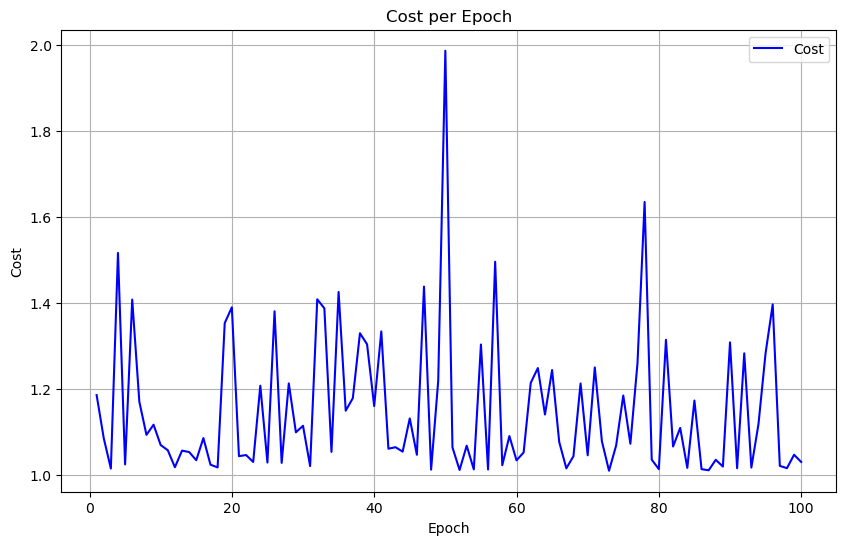

In [36]:
plot_cost(cost_stochastic)

### Mini-batch Technique

In [40]:
def create_batches(data, batch_size):
    """
    Divide a vector into batches of a specified size.

    Parameters:
    data (array): The input vector containing M data points.
    batch_size (int): The size of each batch.

    Returns:
    list: A list of arrays, each array representing a batch of data.
    """
    # Calculate the total number of batches needed
    num_batches = (len(data) + batch_size - 1) // batch_size

    # Create a list to store the batches
    batches = []

    # Loop over the number of batches
    for i in range(num_batches):
        # Calculate the start index of the current batch
        start_idx = i * batch_size
        # Calculate the end index of the current batch
        end_idx = min((i + 1) * batch_size, len(data))
        # Extract the current batch from the input data and append it to the list of batches
        batches.append(data[start_idx:end_idx])

    # Return the list of batches
    return batches

In [48]:
def minibatch_train(data, cost_function, epochs, batch_size, learning_rate=0.01):
    weights = np.array([0.0, 0.0, 0.0, 0.0])
    cost = np.zeros(epochs)
    batches = create_batches(data,batch_size)

    for epoch in range(epochs):
        available_indices = list(range(len(batches)))
        for batch in range(len(batches)):
            selected_index = random.choice(available_indices)
            grad = gradient_batch(cost_function, weights, batches[selected_index])
            weights = weights - learning_rate * grad

        y_pred = predict_batch(data, weights)
        mse = cost_function(data, y_pred)
        cost[epoch] = mse

        print(str(epoch + 1) + '/' + str(epochs) + '--------------------------------------------------------------------------')
        print('MSE = ', mse, 'Weights = ', weights)

    return weights, cost    

In [44]:
batches = create_batches(data, 32)
len(batches)

313

In [57]:
weights_minibatch, cost_minibatch = minibatch_train(data, mean_square_error_batch, 100, 32, learning_rate=0.001)

1/100--------------------------------------------------------------------------
MSE =  1.4166019863229953 Weights =  [-1.37797184  0.57357334  0.4530449   0.43177786]
2/100--------------------------------------------------------------------------
MSE =  1.0987692098931843 Weights =  [-1.49139676  0.68112773  0.69733587  0.47848285]
3/100--------------------------------------------------------------------------
MSE =  1.03371575280382 Weights =  [-1.49675002  0.70374446  0.82564338  0.48740337]
4/100--------------------------------------------------------------------------
MSE =  1.0257202498529088 Weights =  [-1.5008547   0.72289353  0.89057185  0.49032124]
5/100--------------------------------------------------------------------------
MSE =  1.0125952487820258 Weights =  [-1.51487144  0.71041612  0.92338798  0.49303892]
6/100--------------------------------------------------------------------------
MSE =  1.010830918104436 Weights =  [-1.4969834   0.7104885   0.95760001  0.49092823]
7

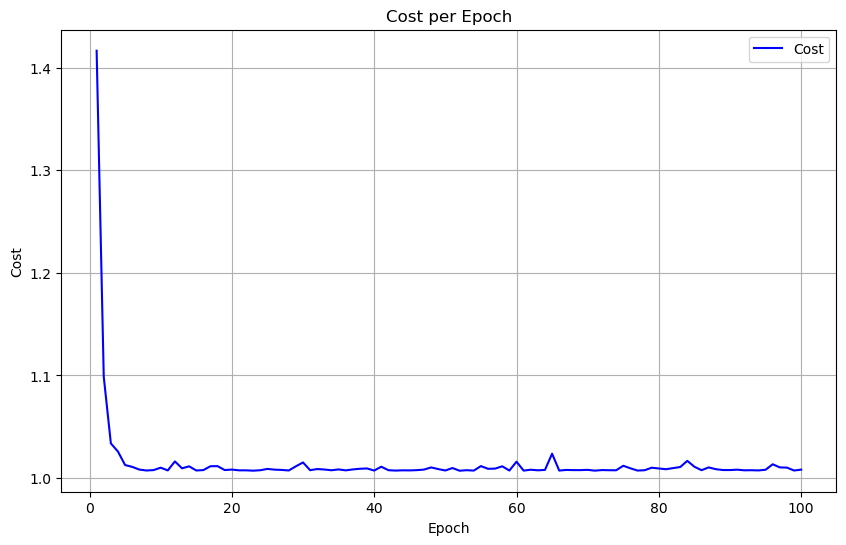

In [58]:
plot_cost(cost_minibatch)